# Data preparation and exploration

We prepare the KLIFS dataset to be used for `kissim` encoding and comparison.

- Fetch all structures in KLIFS (metadata).
- Filter dataset by
  - Species
  - DFG conformation (optional)
  - Resolution
  - Quality score
  - No mutations in the pocket
  - Best struture per kinase-PDB pair
- Save the KLIFS structure IDs for the filtered dataset.

__Note__: The KLIFS data is prepared only on the basis of the structures' metadata from KLIFS. Additional filtering will happen during fingerprint generation, where the actual structural data (coordiantes ect.) are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging

import pandas as pd
from opencadd.databases.klifs import setup_remote, setup_local

from src.data.structures import filters, explorer

In [3]:
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", 50)

In [4]:
SPECIES = "Human"
RESOLUTION_MAX = 3
QUALITYSCORE_MIN = 4

HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"

## Fetch structures (metadata)

In [5]:
klifs_session = setup_local(DATA / "external/structures/20210630_KLIFS_HUMAN")

structures = klifs_session.structures.all_structures()
print(structures.shape)
structures.head()

INFO:opencadd.databases.klifs.api:Set up local session...
INFO:opencadd.databases.klifs.local:Load overview.csv...
INFO:opencadd.databases.klifs.local:Load KLIFS_export.csv...
INFO:opencadd.databases.klifs.local:Merge both csv files...
INFO:opencadd.databases.klifs.local:Add paths to coordinate folders to structures...
INFO:opencadd.databases.klifs.local:Add KLIFS IDs to structures (uses remote since not available locally!)...
INFO:opencadd.databases.klifs.api:Local session is ready!


(11693, 41)


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,1,3dko,A,A,Human,415,EphA7,Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altA_chainA
1,3,3dko,B,A,Human,415,EphA7,Eph,TK,RVIGA_EFGEVCSVAIKTLDFLCEASIMGQFDPNVVHLEGVMIVIE...,IHZ,-,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,-,out,in,2.00,8.1,3,7,0.944,2.254,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,True,False,False,NaN,NaN,NaN,HUMAN/EphA7/3dko_altB_chainA
2,5,3v8t,B,A,Human,474,ITK,Tec,TK,QEIGSG___LVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,477,-,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",-,in,in,2.00,7.8,4,6,0.842,2.047,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/3v8t_altB_chainA
3,6,4kio,A,D,Human,474,ITK,Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G6K,-,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,8.6,1,10,0.842,2.151,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altA_chainD
4,7,4kio,B,C,Human,474,ITK,Tec,TK,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,G5K,-,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",-,in,in,2.18,9.0,0,10,0.840,2.148,<NA>,<NA>,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/ITK/4kio_altB_chainC


In [6]:
klifs_session = setup_remote()

kinases_short = klifs_session.kinases.all_kinases()
kinases = klifs_session.kinases.by_kinase_klifs_id(kinases_short["kinase.klifs_id"].to_list())
structures = pd.merge(structures, kinases[["kinase.klifs_id", "kinase.pocket"]])

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


## Explore structures in full dataset

### Species, DFG/aC-helix conformations, ligand

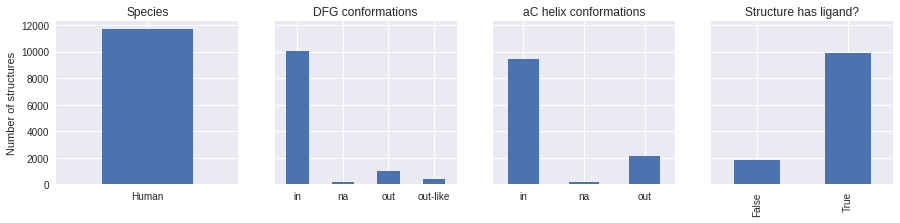

In [7]:
explorer.plot_important_categories(structures);

### Resolution vs. quality score

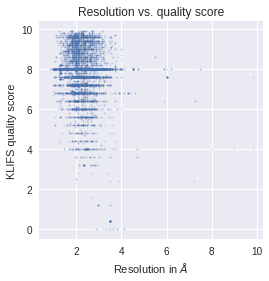

In [8]:
explorer.plot_resolution_vs_qualityscore(structures);

### Number of structures per kinase-PDB pair

How many kinase-PDB pairs are represented by how many structures?

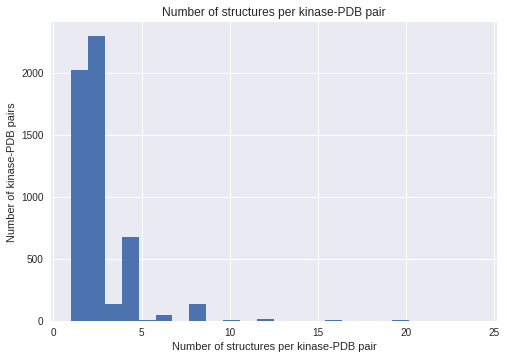

In [9]:
explorer.plot_number_of_structures_per_kinase_pdb_pair(structures);

## Filter and save structures

### DFG-all

In [10]:
%%time

structures_filtered = (
    structures.pipe(filters.make_copy)
    .pipe(filters.select_species, SPECIES)
    # .pipe(filters.select_dfg, DFG_CONFORMATION)
    .pipe(filters.select_resolution, RESOLUTION_MAX)
    .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
    .pipe(filters.select_without_mutations)
    .pipe(filters.select_best_pdb_kinase_pairs)
)
structures_filtered.reset_index(inplace=True, drop=True)
structures_filtered["structure.klifs_id"].sort_values().to_csv(
    DATA / "processed/structure_klifs_ids_all.txt", index=None, header=None
)
print(f"Number of kinases: {len(structures_filtered['kinase.klifs_name'].drop_duplicates())}")

INFO:src.data.structures.filters:make_copy                       11693 structures (-1 day, 23:59:59.994010s)
INFO:src.data.structures.filters:select_species                  11693 structures (-1 day, 23:59:59.987739s)
INFO:src.data.structures.filters:select_resolution               10665 structures (-1 day, 23:59:59.988532s)
INFO:src.data.structures.filters:select_qualityscore             10611 structures (-1 day, 23:59:59.988455s)
INFO:src.data.structures.filters:select_without_mutations         9098 structures (-1 day, 23:58:44.746627s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4198 structures (-1 day, 23:59:59.978583s)


Number of kinases: 279
CPU times: user 1min 15s, sys: 4.08 ms, total: 1min 15s
Wall time: 1min 15s


### DFG-in / DFG-out

In [11]:
%%time

for dfg_conformation in ["in", "out"]:
    structures_filtered = (
        structures.pipe(filters.make_copy)
        .pipe(filters.select_species, SPECIES)
        .pipe(filters.select_resolution, RESOLUTION_MAX)
        .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
        .pipe(filters.select_dfg, dfg_conformation)
        .pipe(filters.select_without_mutations)
        .pipe(filters.select_best_pdb_kinase_pairs)
    )
    structures_filtered.reset_index(inplace=True, drop=True)
    structures_filtered["structure.klifs_id"].sort_values().to_csv(
        DATA / f"processed/structure_klifs_ids_dfg_{dfg_conformation}.txt", index=None, header=None
    )
    print(f"Number of kinases ({dfg_conformation}): {len(structures_filtered['kinase.klifs_name'].drop_duplicates())}")

INFO:src.data.structures.filters:make_copy                       11693 structures (-1 day, 23:59:59.996513s)
INFO:src.data.structures.filters:select_species                  11693 structures (-1 day, 23:59:59.990715s)
INFO:src.data.structures.filters:select_resolution               10665 structures (-1 day, 23:59:59.991329s)
INFO:src.data.structures.filters:select_qualityscore             10611 structures (-1 day, 23:59:59.992628s)
INFO:src.data.structures.filters:select_dfg                       9228 structures (-1 day, 23:59:59.992876s)
INFO:src.data.structures.filters:select_without_mutations         7963 structures (-1 day, 23:58:55.663700s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     3661 structures (-1 day, 23:59:59.980685s)
INFO:src.data.structures.filters:make_copy                       11693 structures (-1 day, 23:59:59.996583s)
INFO:src.data.structures.filters:select_species                  11693 structures (-1 day, 23:59:59.992647s)
INFO:src.data.struc

Number of kinases (in): 257


INFO:src.data.structures.filters:select_without_mutations          724 structures (-1 day, 23:59:53.754499s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs      368 structures (-1 day, 23:59:59.991218s)


Number of kinases (out): 71
CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 10s
